# IMU log parsing and plots

Parse `serial.log` produced by `arduino-cli monitor`, then plot acceleration (g) and gyro (dps

,ax_g,ay_g,az_g,gx_dps,gy_dps,gz_dps,t_s
0,NaN,NaN,NaN,-0.70,2.61,-0.70,0.0
1,0.05,0.60,-0.78,-0.11,2.67,-0.41,0.5
2,0.05,0.60,-0.78,0.09,2.79,-0.37,1.0
3,0.05,0.61,-0.78,-0.37,2.79,-0.55,1.5
4,0.05,0.60,-0.78,-0.26,2.56,-0.69,2.0


'rows: 44'

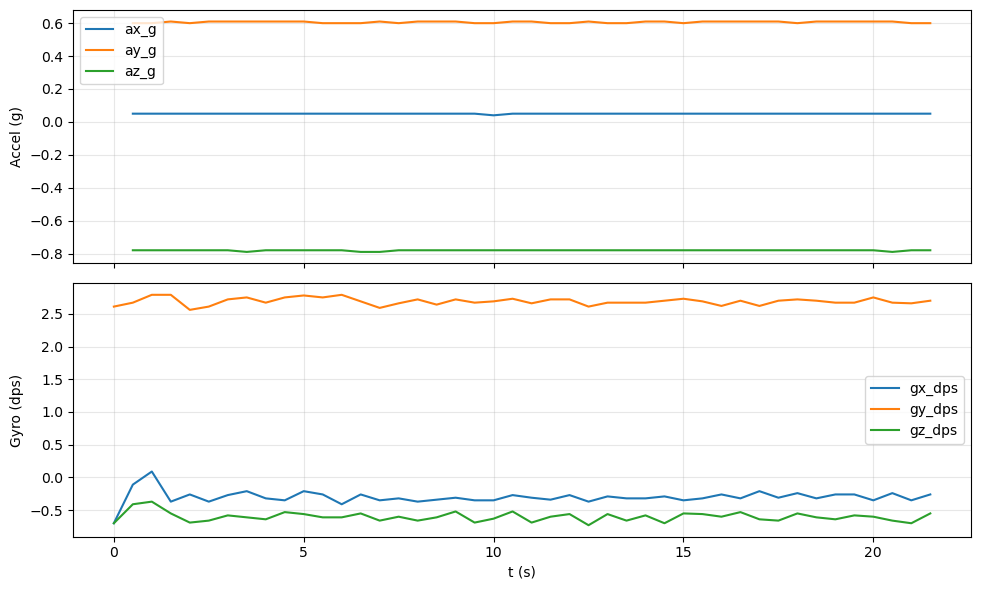

In [1]:
from io import StringIO
import re
import pandas as pd
import matplotlib.pyplot as plt

raw_data = """
0.04, Y: 0.60, Z: -0.78 g

Rotation X: -0.70, Y: 2.61, Z: -0.70 dps

Acceleration X: 0.05, Y: 0.60, Z: -0.78 g

Rotation X: -0.11, Y: 2.67, Z: -0.41 dps

Acceleration X: 0.05, Y: 0.60, Z: -0.78 g

Rotation X: 0.09, Y: 2.79, Z: -0.37 dps

WHO_AM_I = 0x98

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g

Rotation X: -0.37, Y: 2.79, Z: -0.55 dps

Acceleration X: 0.05, Y: 0.60, Z: -0.78 g

Rotation X: -0.26, Y: 2.56, Z: -0.69 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g

Rotation X: -0.37, Y: 2.61, Z: -0.66 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g

Rotation X: -0.27, Y: 2.72, Z: -0.58 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.79 g

Rotation X: -0.21, Y: 2.75, Z: -0.61 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g

Rotation X: -0.32, Y: 2.67, Z: -0.64 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g

Rotation X: -0.35, Y: 2.75, Z: -0.53 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g

Rotation X: -0.21, Y: 2.78, Z: -0.56 dps

Acceleration X: 0.05, Y: 0.60, Z: -0.78 g

Rotation X: -0.26, Y: 2.75, Z: -0.61 dps

Acceleration X: 0.05, Y: 0.60, Z: -0.78 g

Rotation X: -0.41, Y: 2.79, Z: -0.61 dps

Acceleration X: 0.05, Y: 0.60, Z: -0.79 g

Rotation X: -0.26, Y: 2.69, Z: -0.55 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.79 g

Rotation X: -0.35, Y: 2.59, Z: -0.66 dps

Acceleration X: 0.05, Y: 0.60, Z: -0.78 g

Rotation X: -0.32, Y: 2.66, Z: -0.60 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g

Rotation X: -0.37, Y: 2.72, Z: -0.66 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g

Rotation X: -0.34, Y: 2.64, Z: -0.61 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g

Rotation X: -0.31, Y: 2.72, Z: -0.52 dps

Acceleration X: 0.05, Y: 0.60, Z: -0.78 g

Rotation X: -0.35, Y: 2.67, Z: -0.69 dps

Acceleration X: 0.04, Y: 0.60, Z: -0.78 g

Rotation X: -0.35, Y: 2.69, Z: -0.63 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g

Rotation X: -0.27, Y: 2.73, Z: -0.52 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g

Rotation X: -0.31, Y: 2.66, Z: -0.69 dps

Acceleration X: 0.05, Y: 0.60, Z: -0.78 g

Rotation X: -0.34, Y: 2.72, Z: -0.60 dps

Acceleration X: 0.05, Y: 0.60, Z: -0.78 g

Rotation X: -0.27, Y: 2.72, Z: -0.56 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g

Rotation X: -0.37, Y: 2.61, Z: -0.73 dps

Acceleration X: 0.05, Y: 0.60, Z: -0.78 g

Rotation X: -0.29, Y: 2.67, Z: -0.56 dps

Acceleration X: 0.05, Y: 0.60, Z: -0.78 g

Rotation X: -0.32, Y: 2.67, Z: -0.66 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g

Rotation X: -0.32, Y: 2.67, Z: -0.58 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g

Rotation X: -0.29, Y: 2.70, Z: -0.70 dps

Acceleration X: 0.05, Y: 0.60, Z: -0.78 g

Rotation X: -0.35, Y: 2.73, Z: -0.55 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g

Rotation X: -0.32, Y: 2.69, Z: -0.56 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g

Rotation X: -0.26, Y: 2.62, Z: -0.60 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g

Rotation X: -0.32, Y: 2.70, Z: -0.53 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g

Rotation X: -0.21, Y: 2.62, Z: -0.64 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g

Rotation X: -0.31, Y: 2.70, Z: -0.66 dps

Acceleration X: 0.05, Y: 0.60, Z: -0.78 g

Rotation X: -0.24, Y: 2.72, Z: -0.55 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g

Rotation X: -0.32, Y: 2.70, Z: -0.61 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g

Rotation X: -0.26, Y: 2.67, Z: -0.64 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g

Rotation X: -0.26, Y: 2.67, Z: -0.58 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g

Rotation X: -0.35, Y: 2.75, Z: -0.60 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.79 g

Rotation X: -0.24, Y: 2.67, Z: -0.66 dps

Acceleration X: 0.05, Y: 0.60, Z: -0.78 g

Rotation X: -0.35, Y: 2.66, Z: -0.70 dps

Acceleration X: 0.05, Y: 0.60, Z: -0.78 g

Rotation X: -0.26, Y: 2.70, Z: -0.55 dps
"""


def parse_block(raw: str, dt_s: float = 0.5):
    acc_pat = re.compile(r"Acceleration X:\s*([-0-9.+eE]+),\s*Y:\s*([-0-9.+eE]+),\s*Z:\s*([-0-9.+eE]+)\s*g")
    gyro_pat = re.compile(r"Rotation X:\s*([-0-9.+eE]+),\s*Y:\s*([-0-9.+eE]+),\s*Z:\s*([-0-9.+eE]+)\s*dps")
    rows = []
    ax = ay = az = None
    for line in StringIO(raw):
        m_acc = acc_pat.search(line)
        m_gyro = gyro_pat.search(line)
        if m_acc:
            ax, ay, az = map(float, m_acc.groups())
        if m_gyro:
            gx, gy, gz = map(float, m_gyro.groups())
            rows.append({
                "ax_g": ax, "ay_g": ay, "az_g": az,
                "gx_dps": gx, "gy_dps": gy, "gz_dps": gz,
            })
    df_out = pd.DataFrame(rows)
    if not df_out.empty:
        df_out["t_s"] = df_out.index * dt_s
    return df_out

# dt_s ~0.5s from your sketch's 500 ms print interval; change if needed
df_pasted = parse_block(raw_data, dt_s=0.5)
display(df_pasted.head(), f"rows: {len(df_pasted)}")

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

df_pasted.plot(x="t_s", y=["ax_g", "ay_g", "az_g"], ax=axes[0])
axes[0].set_ylabel("Accel (g)")
axes[0].set_xlabel("t (s)")
axes[0].grid(True, alpha=0.3)

df_pasted.plot(x="t_s", y=["gx_dps", "gy_dps", "gz_dps"], ax=axes[1])
axes[1].set_ylabel("Gyro (dps)")
axes[1].set_xlabel("t (s)")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


   ax_g  ay_g  az_g  gx_dps  gy_dps  gz_dps  t_s
0  0.17  0.64 -0.74   -0.29    3.01    0.21  0.0
1  0.17  0.64 -0.74   -0.31    2.75   -0.32  0.5
2  0.18  0.64 -0.74   -0.32    2.70   -0.55  1.0
3  0.18  0.64 -0.74   -0.26    2.69   -0.75  1.5
4  0.17  0.64 -0.74   -0.26    2.38   -1.62  2.0
rows: 99


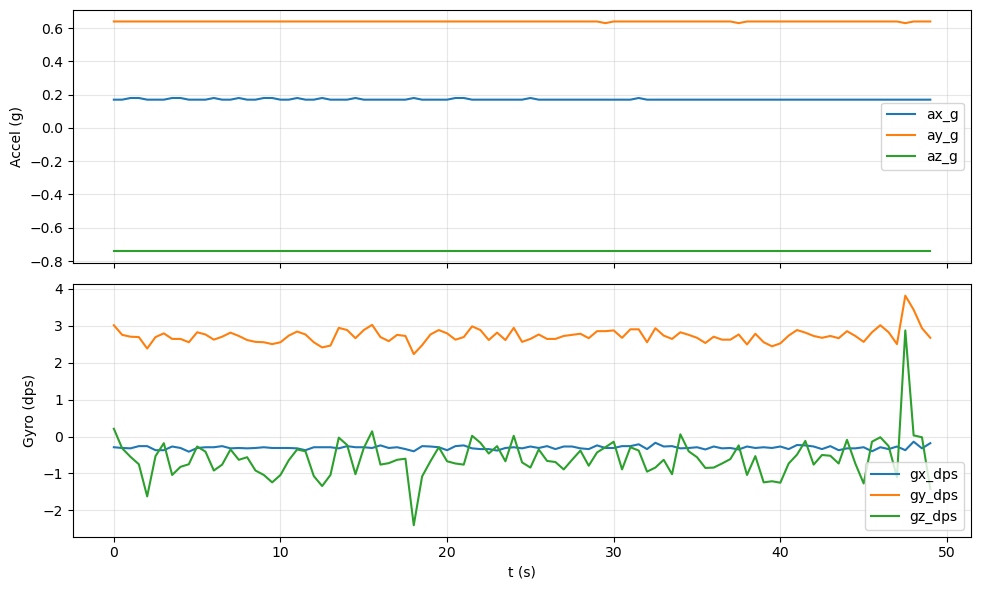

In [2]:
from pathlib import Path
from io import StringIO
import re
import pandas as pd
import matplotlib.pyplot as plt

LOG_PATH = Path("/mnt/c/Users/tjsin/Downloads/Competition/LINE-FOLLOWER/serial.log")
DT_S = 0.5  # seconds between samples; adjust to your print interval

# Optional pasted fallback (leave empty to skip)
RAW_FALLBACK = """
Acceleration X: 0.04, Y: 0.60, Z: -0.78 g
Rotation X: -0.70, Y: 2.61, Z: -0.70 dps

Acceleration X: 0.05, Y: 0.60, Z: -0.78 g
Rotation X: -0.11, Y: 2.67, Z: -0.41 dps

Acceleration X: 0.05, Y: 0.60, Z: -0.78 g
Rotation X: 0.09, Y: 2.79, Z: -0.37 dps

WHO_AM_I = 0x98

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g
Rotation X: -0.37, Y: 2.79, Z: -0.55 dps

Acceleration X: 0.05, Y: 0.60, Z: -0.78 g
Rotation X: -0.26, Y: 2.56, Z: -0.69 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g
Rotation X: -0.37, Y: 2.61, Z: -0.66 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g
Rotation X: -0.27, Y: 2.72, Z: -0.58 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.79 g
Rotation X: -0.21, Y: 2.75, Z: -0.61 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g
Rotation X: -0.32, Y: 2.67, Z: -0.64 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g
Rotation X: -0.35, Y: 2.75, Z: -0.53 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g
Rotation X: -0.21, Y: 2.78, Z: -0.56 dps

Acceleration X: 0.05, Y: 0.60, Z: -0.78 g
Rotation X: -0.26, Y: 2.75, Z: -0.61 dps

Acceleration X: 0.05, Y: 0.60, Z: -0.78 g
Rotation X: -0.41, Y: 2.79, Z: -0.61 dps

Acceleration X: 0.05, Y: 0.60, Z: -0.79 g
Rotation X: -0.26, Y: 2.69, Z: -0.55 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.79 g
Rotation X: -0.35, Y: 2.59, Z: -0.66 dps

Acceleration X: 0.05, Y: 0.60, Z: -0.78 g
Rotation X: -0.32, Y: 2.66, Z: -0.60 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g
Rotation X: -0.37, Y: 2.72, Z: -0.66 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g
Rotation X: -0.34, Y: 2.64, Z: -0.61 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g
Rotation X: -0.31, Y: 2.72, Z: -0.52 dps

Acceleration X: 0.05, Y: 0.60, Z: -0.78 g
Rotation X: -0.35, Y: 2.67, Z: -0.69 dps

Acceleration X: 0.04, Y: 0.60, Z: -0.78 g
Rotation X: -0.35, Y: 2.69, Z: -0.63 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g
Rotation X: -0.27, Y: 2.73, Z: -0.52 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g
Rotation X: -0.31, Y: 2.66, Z: -0.69 dps

Acceleration X: 0.05, Y: 0.60, Z: -0.78 g
Rotation X: -0.34, Y: 2.72, Z: -0.60 dps

Acceleration X: 0.05, Y: 0.60, Z: -0.78 g
Rotation X: -0.27, Y: 2.72, Z: -0.56 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g
Rotation X: -0.37, Y: 2.61, Z: -0.73 dps

Acceleration X: 0.05, Y: 0.60, Z: -0.78 g
Rotation X: -0.29, Y: 2.67, Z: -0.56 dps

Acceleration X: 0.05, Y: 0.60, Z: -0.78 g
Rotation X: -0.32, Y: 2.67, Z: -0.66 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g
Rotation X: -0.32, Y: 2.67, Z: -0.58 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g
Rotation X: -0.29, Y: 2.70, Z: -0.70 dps

Acceleration X: 0.05, Y: 0.60, Z: -0.78 g
Rotation X: -0.35, Y: 2.73, Z: -0.55 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g
Rotation X: -0.32, Y: 2.69, Z: -0.56 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g
Rotation X: -0.26, Y: 2.62, Z: -0.60 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g
Rotation X: -0.32, Y: 2.70, Z: -0.53 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g
Rotation X: -0.21, Y: 2.62, Z: -0.64 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g
Rotation X: -0.31, Y: 2.70, Z: -0.66 dps

Acceleration X: 0.05, Y: 0.60, Z: -0.78 g
Rotation X: -0.24, Y: 2.72, Z: -0.55 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g
Rotation X: -0.32, Y: 2.70, Z: -0.61 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g
Rotation X: -0.26, Y: 2.67, Z: -0.64 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g
Rotation X: -0.26, Y: 2.67, Z: -0.58 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.78 g
Rotation X: -0.35, Y: 2.75, Z: -0.60 dps

Acceleration X: 0.05, Y: 0.61, Z: -0.79 g
Rotation X: -0.24, Y: 2.67, Z: -0.66 dps

Acceleration X: 0.05, Y: 0.60, Z: -0.78 g
Rotation X: -0.35, Y: 2.66, Z: -0.70 dps

Acceleration X: 0.05, Y: 0.60, Z: -0.78 g
Rotation X: -0.26, Y: 2.70, Z: -0.55 dps
"""

def parse_lines(lines, dt_s=0.5):
    acc_pat = re.compile(r"Acceleration X:\s*([-0-9.+eE]+),\s*Y:\s*([-0-9.+eE]+),\s*Z:\s*([-0-9.+eE]+)\s*g")
    gyro_pat = re.compile(r"Rotation X:\s*([-0-9.+eE]+),\s*Y:\s*([-0-9.+eE]+),\s*Z:\s*([-0-9.+eE]+)\s*dps")
    rows = []
    ax = ay = az = None
    for line in lines:
        m_acc = acc_pat.search(line)
        m_gyro = gyro_pat.search(line)
        if m_acc:
            ax, ay, az = map(float, m_acc.groups())
        if m_gyro:
            gx, gy, gz = map(float, m_gyro.groups())
            rows.append({
                "ax_g": ax, "ay_g": ay, "az_g": az,
                "gx_dps": gx, "gy_dps": gy, "gz_dps": gz,
            })
    df = pd.DataFrame(rows)
    if not df.empty:
        df["t_s"] = df.index * dt_s
    return df

# Load from serial.log if present
lines = []
if LOG_PATH.exists():
    lines = LOG_PATH.read_text().splitlines()

df = parse_lines(lines, dt_s=DT_S)

# Fallback to pasted block if log was empty and fallback provided
if df.empty and RAW_FALLBACK.strip():
    print("serial.log empty; using fallback block")
    df = parse_lines(StringIO(RAW_FALLBACK), dt_s=DT_S)

print(df.head())
print("rows:", len(df))

if df.empty:
    print("No data available to plot.")
else:
    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    df.plot(x="t_s", y=["ax_g", "ay_g", "az_g"], ax=axes[0])
    axes[0].set_ylabel("Accel (g)")
    axes[0].set_xlabel("t (s)")
    axes[0].grid(True, alpha=0.3)

    df.plot(x="t_s", y=["gx_dps", "gy_dps", "gz_dps"], ax=axes[1])
    axes[1].set_ylabel("Gyro (dps)")
    axes[1].set_xlabel("t (s)")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()



                    ts  ax_g  ay_g  az_g  gx_dps  gy_dps  gz_dps  \
0  2025-12-09 01:52:35  0.17  0.64 -0.74   -0.29    3.01    0.21   
1  2025-12-09 01:52:36  0.17  0.64 -0.74   -0.31    2.75   -0.32   
2  2025-12-09 01:52:36  0.18  0.64 -0.74   -0.32    2.70   -0.55   
3  2025-12-09 01:52:37  0.18  0.64 -0.74   -0.26    2.69   -0.75   
4  2025-12-09 01:52:37  0.17  0.64 -0.74   -0.26    2.38   -1.62   

                 t_dt  t_s  
0 2025-12-09 01:52:35  0.0  
1 2025-12-09 01:52:36  1.0  
2 2025-12-09 01:52:36  1.0  
3 2025-12-09 01:52:37  2.0  
4 2025-12-09 01:52:37  2.0  
rows: 99


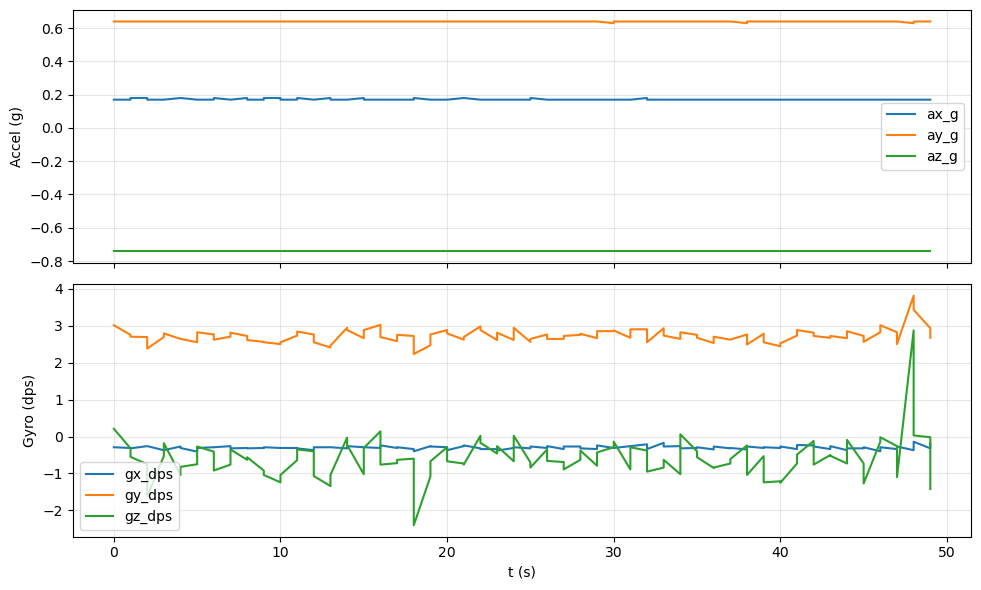

In [3]:
from datetime import datetime
from io import StringIO
import re
import pandas as pd
import matplotlib.pyplot as plt

raw_timed = """
[2025-12-09 01:52:35] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:35] Rotation X: -0.29, Y: 3.01, Z: 0.21 dps
[2025-12-09 01:52:35]
[2025-12-09 01:52:36] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:36] Rotation X: -0.31, Y: 2.75, Z: -0.32 dps
[2025-12-09 01:52:36]
[2025-12-09 01:52:36] Acceleration X: 0.18, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:36] Rotation X: -0.32, Y: 2.70, Z: -0.55 dps
[2025-12-09 01:52:36]
[2025-12-09 01:52:37] Acceleration X: 0.18, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:37] Rotation X: -0.26, Y: 2.69, Z: -0.75 dps
[2025-12-09 01:52:37]
[2025-12-09 01:52:37] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:37] Rotation X: -0.26, Y: 2.38, Z: -1.62 dps
[2025-12-09 01:52:37]
[2025-12-09 01:52:38] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:38] Rotation X: -0.37, Y: 2.69, Z: -0.53 dps
[2025-12-09 01:52:38]
[2025-12-09 01:52:38] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:38] Rotation X: -0.37, Y: 2.79, Z: -0.18 dps
[2025-12-09 01:52:38]
[2025-12-09 01:52:39] Acceleration X: 0.18, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:39] Rotation X: -0.27, Y: 2.64, Z: -1.04 dps
[2025-12-09 01:52:39]
[2025-12-09 01:52:39] Acceleration X: 0.18, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:39] Rotation X: -0.31, Y: 2.64, Z: -0.82 dps
[2025-12-09 01:52:39]
[2025-12-09 01:52:40] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:40] Rotation X: -0.41, Y: 2.55, Z: -0.75 dps
[2025-12-09 01:52:40]
[2025-12-09 01:52:40] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:40] Rotation X: -0.31, Y: 2.82, Z: -0.27 dps
[2025-12-09 01:52:40]
[2025-12-09 01:52:41] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:41] Rotation X: -0.29, Y: 2.76, Z: -0.41 dps
[2025-12-09 01:52:41]
[2025-12-09 01:52:41] Acceleration X: 0.18, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:41] Rotation X: -0.29, Y: 2.62, Z: -0.92 dps
[2025-12-09 01:52:41]
[2025-12-09 01:52:42] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:42] Rotation X: -0.26, Y: 2.70, Z: -0.76 dps
[2025-12-09 01:52:42]
[2025-12-09 01:52:42] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:42] Rotation X: -0.32, Y: 2.81, Z: -0.35 dps
[2025-12-09 01:52:42]
[2025-12-09 01:52:43] Acceleration X: 0.18, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:43] Rotation X: -0.31, Y: 2.72, Z: -0.63 dps
[2025-12-09 01:52:43]
[2025-12-09 01:52:43] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:43] Rotation X: -0.32, Y: 2.61, Z: -0.56 dps
[2025-12-09 01:52:43]
[2025-12-09 01:52:44] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:44] Rotation X: -0.31, Y: 2.56, Z: -0.92 dps
[2025-12-09 01:52:44]
[2025-12-09 01:52:44] Acceleration X: 0.18, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:44] Rotation X: -0.29, Y: 2.55, Z: -1.04 dps
[2025-12-09 01:52:44]
[2025-12-09 01:52:45] Acceleration X: 0.18, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:45] Rotation X: -0.31, Y: 2.50, Z: -1.24 dps
[2025-12-09 01:52:45]
[2025-12-09 01:52:45] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:45] Rotation X: -0.31, Y: 2.55, Z: -1.04 dps
[2025-12-09 01:52:45]
[2025-12-09 01:52:46] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:46] Rotation X: -0.31, Y: 2.73, Z: -0.64 dps
[2025-12-09 01:52:46]
[2025-12-09 01:52:46] Acceleration X: 0.18, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:46] Rotation X: -0.32, Y: 2.84, Z: -0.35 dps
[2025-12-09 01:52:46]
[2025-12-09 01:52:47] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:47] Rotation X: -0.37, Y: 2.76, Z: -0.40 dps
[2025-12-09 01:52:47]
[2025-12-09 01:52:47] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:47] Rotation X: -0.29, Y: 2.55, Z: -1.07 dps
[2025-12-09 01:52:47]
[2025-12-09 01:52:48] Acceleration X: 0.18, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:48] Rotation X: -0.29, Y: 2.41, Z: -1.34 dps
[2025-12-09 01:52:48]
[2025-12-09 01:52:48] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:48] Rotation X: -0.29, Y: 2.46, Z: -1.04 dps
[2025-12-09 01:52:48]
[2025-12-09 01:52:49] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:49] Rotation X: -0.32, Y: 2.94, Z: -0.03 dps
[2025-12-09 01:52:49]
[2025-12-09 01:52:49] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:49] Rotation X: -0.26, Y: 2.88, Z: -0.23 dps
[2025-12-09 01:52:49]
[2025-12-09 01:52:50] Acceleration X: 0.18, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:50] Rotation X: -0.29, Y: 2.66, Z: -1.02 dps
[2025-12-09 01:52:50]
[2025-12-09 01:52:50] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:50] Rotation X: -0.29, Y: 2.88, Z: -0.31 dps
[2025-12-09 01:52:50]
[2025-12-09 01:52:51] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:51] Rotation X: -0.31, Y: 3.02, Z: 0.14 dps
[2025-12-09 01:52:51]
[2025-12-09 01:52:51] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:51] Rotation X: -0.24, Y: 2.69, Z: -0.76 dps
[2025-12-09 01:52:51]
[2025-12-09 01:52:52] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:52] Rotation X: -0.31, Y: 2.58, Z: -0.72 dps
[2025-12-09 01:52:52]
[2025-12-09 01:52:52] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:52] Rotation X: -0.29, Y: 2.75, Z: -0.63 dps
[2025-12-09 01:52:52]
[2025-12-09 01:52:53] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:53] Rotation X: -0.34, Y: 2.72, Z: -0.60 dps
[2025-12-09 01:52:53]
[2025-12-09 01:52:53] Acceleration X: 0.18, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:53] Rotation X: -0.40, Y: 2.23, Z: -2.40 dps
[2025-12-09 01:52:53]
[2025-12-09 01:52:54] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:54] Rotation X: -0.26, Y: 2.47, Z: -1.08 dps
[2025-12-09 01:52:54]
[2025-12-09 01:52:54] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:54] Rotation X: -0.27, Y: 2.76, Z: -0.67 dps
[2025-12-09 01:52:54]
[2025-12-09 01:52:55] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:55] Rotation X: -0.29, Y: 2.88, Z: -0.29 dps
[2025-12-09 01:52:55]
[2025-12-09 01:52:55] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:55] Rotation X: -0.37, Y: 2.79, Z: -0.67 dps
[2025-12-09 01:52:55]
[2025-12-09 01:52:56] Acceleration X: 0.18, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:56] Rotation X: -0.26, Y: 2.62, Z: -0.73 dps
[2025-12-09 01:52:56]
[2025-12-09 01:52:56] Acceleration X: 0.18, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:56] Rotation X: -0.24, Y: 2.69, Z: -0.76 dps
[2025-12-09 01:52:56]
[2025-12-09 01:52:57] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:57] Rotation X: -0.32, Y: 2.98, Z: 0.02 dps
[2025-12-09 01:52:57]
[2025-12-09 01:52:57] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:57] Rotation X: -0.34, Y: 2.88, Z: -0.17 dps
[2025-12-09 01:52:57]
[2025-12-09 01:52:58] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:58] Rotation X: -0.34, Y: 2.61, Z: -0.46 dps
[2025-12-09 01:52:58]
[2025-12-09 01:52:58] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:58] Rotation X: -0.38, Y: 2.81, Z: -0.26 dps
[2025-12-09 01:52:58]
[2025-12-09 01:52:59] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:59] Rotation X: -0.31, Y: 2.61, Z: -0.67 dps
[2025-12-09 01:52:59]
[2025-12-09 01:52:59] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:52:59] Rotation X: -0.29, Y: 2.94, Z: 0.02 dps
[2025-12-09 01:52:59]
[2025-12-09 01:53:00] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:00] Rotation X: -0.32, Y: 2.56, Z: -0.70 dps
[2025-12-09 01:53:00]
[2025-12-09 01:53:00] Acceleration X: 0.18, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:00] Rotation X: -0.27, Y: 2.64, Z: -0.84 dps
[2025-12-09 01:53:00]
[2025-12-09 01:53:01] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:01] Rotation X: -0.31, Y: 2.76, Z: -0.35 dps
[2025-12-09 01:53:01]
[2025-12-09 01:53:01] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:01] Rotation X: -0.26, Y: 2.64, Z: -0.66 dps
[2025-12-09 01:53:01]
[2025-12-09 01:53:02] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:02] Rotation X: -0.34, Y: 2.64, Z: -0.69 dps
[2025-12-09 01:53:02]
[2025-12-09 01:53:02] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:02] Rotation X: -0.27, Y: 2.72, Z: -0.89 dps
[2025-12-09 01:53:02]
[2025-12-09 01:53:03] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:03] Rotation X: -0.27, Y: 2.75, Z: -0.63 dps
[2025-12-09 01:53:03]
[2025-12-09 01:53:03] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:03] Rotation X: -0.32, Y: 2.78, Z: -0.38 dps
[2025-12-09 01:53:03]
[2025-12-09 01:53:04] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:04] Rotation X: -0.34, Y: 2.66, Z: -0.79 dps
[2025-12-09 01:53:04]
[2025-12-09 01:53:04] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:04] Rotation X: -0.24, Y: 2.85, Z: -0.43 dps
[2025-12-09 01:53:04]
[2025-12-09 01:53:05] Acceleration X: 0.17, Y: 0.63, Z: -0.74 g
[2025-12-09 01:53:05] Rotation X: -0.31, Y: 2.85, Z: -0.29 dps
[2025-12-09 01:53:05]
[2025-12-09 01:53:05] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:05] Rotation X: -0.31, Y: 2.87, Z: -0.14 dps
[2025-12-09 01:53:05]
[2025-12-09 01:53:06] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:06] Rotation X: -0.26, Y: 2.67, Z: -0.89 dps
[2025-12-09 01:53:06]
[2025-12-09 01:53:06] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:06] Rotation X: -0.26, Y: 2.90, Z: -0.29 dps
[2025-12-09 01:53:06]
[2025-12-09 01:53:07] Acceleration X: 0.18, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:07] Rotation X: -0.21, Y: 2.90, Z: -0.38 dps
[2025-12-09 01:53:07]
[2025-12-09 01:53:07] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:07] Rotation X: -0.34, Y: 2.55, Z: -0.95 dps
[2025-12-09 01:53:07]
[2025-12-09 01:53:08] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:08] Rotation X: -0.17, Y: 2.93, Z: -0.84 dps
[2025-12-09 01:53:08]
[2025-12-09 01:53:08] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:08] Rotation X: -0.27, Y: 2.73, Z: -0.63 dps
[2025-12-09 01:53:08]
[2025-12-09 01:53:09] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:09] Rotation X: -0.26, Y: 2.64, Z: -1.02 dps
[2025-12-09 01:53:09]
[2025-12-09 01:53:09] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:09] Rotation X: -0.32, Y: 2.82, Z: 0.06 dps
[2025-12-09 01:53:09]
[2025-12-09 01:53:10] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:10] Rotation X: -0.31, Y: 2.75, Z: -0.40 dps
[2025-12-09 01:53:10]
[2025-12-09 01:53:10] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:10] Rotation X: -0.29, Y: 2.67, Z: -0.56 dps
[2025-12-09 01:53:10]
[2025-12-09 01:53:11] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:11] Rotation X: -0.35, Y: 2.53, Z: -0.85 dps
[2025-12-09 01:53:11]
[2025-12-09 01:53:11] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:11] Rotation X: -0.27, Y: 2.70, Z: -0.84 dps
[2025-12-09 01:53:11]
[2025-12-09 01:53:12] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:12] Rotation X: -0.32, Y: 2.62, Z: -0.73 dps
[2025-12-09 01:53:12]
[2025-12-09 01:53:12] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:12] Rotation X: -0.31, Y: 2.62, Z: -0.61 dps
[2025-12-09 01:53:12]
[2025-12-09 01:53:13] Acceleration X: 0.17, Y: 0.63, Z: -0.74 g
[2025-12-09 01:53:13] Rotation X: -0.35, Y: 2.76, Z: -0.24 dps
[2025-12-09 01:53:13]
[2025-12-09 01:53:13] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:13] Rotation X: -0.27, Y: 2.49, Z: -1.04 dps
[2025-12-09 01:53:13]
[2025-12-09 01:53:14] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:14] Rotation X: -0.31, Y: 2.78, Z: -0.53 dps
[2025-12-09 01:53:14]
[2025-12-09 01:53:14] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:14] Rotation X: -0.29, Y: 2.55, Z: -1.24 dps
[2025-12-09 01:53:14]
[2025-12-09 01:53:15] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:15] Rotation X: -0.31, Y: 2.44, Z: -1.21 dps
[2025-12-09 01:53:15]
[2025-12-09 01:53:15] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:15] Rotation X: -0.27, Y: 2.52, Z: -1.25 dps
[2025-12-09 01:53:15]
[2025-12-09 01:53:16] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:16] Rotation X: -0.34, Y: 2.73, Z: -0.73 dps
[2025-12-09 01:53:16]
[2025-12-09 01:53:16] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:16] Rotation X: -0.23, Y: 2.88, Z: -0.49 dps
[2025-12-09 01:53:16]
[2025-12-09 01:53:17] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:17] Rotation X: -0.24, Y: 2.81, Z: -0.12 dps
[2025-12-09 01:53:17]
[2025-12-09 01:53:17] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:17] Rotation X: -0.27, Y: 2.72, Z: -0.76 dps
[2025-12-09 01:53:17]
[2025-12-09 01:53:18] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:18] Rotation X: -0.34, Y: 2.67, Z: -0.50 dps
[2025-12-09 01:53:18]
[2025-12-09 01:53:18] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:18] Rotation X: -0.26, Y: 2.72, Z: -0.52 dps
[2025-12-09 01:53:18]
[2025-12-09 01:53:19] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:19] Rotation X: -0.37, Y: 2.66, Z: -0.73 dps
[2025-12-09 01:53:19]
[2025-12-09 01:53:19] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:19] Rotation X: -0.32, Y: 2.85, Z: -0.09 dps
[2025-12-09 01:53:19]
[2025-12-09 01:53:20] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:20] Rotation X: -0.32, Y: 2.72, Z: -0.73 dps
[2025-12-09 01:53:20]
[2025-12-09 01:53:20] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:20] Rotation X: -0.29, Y: 2.56, Z: -1.27 dps
[2025-12-09 01:53:20]
[2025-12-09 01:53:21] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:21] Rotation X: -0.40, Y: 2.82, Z: -0.14 dps
[2025-12-09 01:53:21]
[2025-12-09 01:53:21] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:21] Rotation X: -0.29, Y: 3.01, Z: -0.02 dps
[2025-12-09 01:53:21]
[2025-12-09 01:53:22] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:22] Rotation X: -0.34, Y: 2.82, Z: -0.26 dps
[2025-12-09 01:53:22]
[2025-12-09 01:53:22] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:22] Rotation X: -0.27, Y: 2.50, Z: -1.10 dps
[2025-12-09 01:53:22]
[2025-12-09 01:53:23] Acceleration X: 0.17, Y: 0.63, Z: -0.74 g
[2025-12-09 01:53:23] Rotation X: -0.37, Y: 3.81, Z: 2.87 dps
[2025-12-09 01:53:23]
[2025-12-09 01:53:23] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:23] Rotation X: -0.14, Y: 3.43, Z: 0.03 dps
[2025-12-09 01:53:23]
[2025-12-09 01:53:24] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:24] Rotation X: -0.32, Y: 2.93, Z: -0.02 dps
[2025-12-09 01:53:24]
[2025-12-09 01:53:24] Acceleration X: 0.17, Y: 0.64, Z: -0.74 g
[2025-12-09 01:53:24] Rotation X: -0.18, Y: 2.67, Z: -1.42 dps
[2025-12-09 01:53:24]
"""

def parse_timed_block(raw: str):
    ts_pat = re.compile(r"\[(.*?)\]\s*Acceleration X:\s*([-0-9.+eE]+),\s*Y:\s*([-0-9.+eE]+),\s*Z:\s*([-0-9.+eE]+)\s*g")
    gyro_pat = re.compile(r"\[(.*?)\]\s*Rotation X:\s*([-0-9.+eE]+),\s*Y:\s*([-0-9.+eE]+),\s*Z:\s*([-0-9.+eE]+)\s*dps")
    rows = []
    acc_buf = None
    for line in StringIO(raw):
        m_acc = ts_pat.search(line)
        m_gyr = gyro_pat.search(line)
        if m_acc:
            t_str, ax, ay, az = m_acc.groups()
            acc_buf = (t_str, float(ax), float(ay), float(az))
        if m_gyr and acc_buf:
            t_str, gx, gy, gz = m_gyr.groups()
            # use timestamp from gyro line (or acc) and compute relative seconds later
            rows.append({
                "ts": t_str,
                "ax_g": acc_buf[1], "ay_g": acc_buf[2], "az_g": acc_buf[3],
                "gx_dps": float(gx), "gy_dps": float(gy), "gz_dps": float(gz),
            })
            acc_buf = None
    df = pd.DataFrame(rows)
    if not df.empty:
        df["t_dt"] = pd.to_datetime(df["ts"])
        t0 = df["t_dt"].iloc[0]
        df["t_s"] = (df["t_dt"] - t0).dt.total_seconds()
    return df

# Parse the provided time-stamped block

df_ts = parse_timed_block(raw_timed)
print(df_ts.head())
print("rows:", len(df_ts))

if df_ts.empty:
    print("No data to plot.")
else:
    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    df_ts.plot(x="t_s", y=["ax_g", "ay_g", "az_g"], ax=axes[0])
    axes[0].set_ylabel("Accel (g)")
    axes[0].grid(True, alpha=0.3)

    df_ts.plot(x="t_s", y=["gx_dps", "gy_dps", "gz_dps"], ax=axes[1])
    axes[1].set_ylabel("Gyro (dps)")
    axes[1].set_xlabel("t (s)")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()



,ax_g_lpf,ay_g_lpf,az_g_lpf,gx_dps_lpf,gy_dps_lpf,gz_dps_lpf
0,-0.004000,-1.110223e-16,0.0,0.019000,0.335500,0.882500
1,-0.004000,-1.110223e-16,0.0,0.016000,0.296500,0.803000
2,-0.002500,-1.110223e-16,0.0,0.011950,0.255850,0.700925
3,-0.001225,-1.110223e-16,0.0,0.017508,0.219798,0.584161
4,-0.001641,-1.110223e-16,0.0,0.022231,0.142653,0.354412


,ts,ax_g,ay_g,az_g,gx_dps,gy_dps,gz_dps,t_dt,t_s,dt,gx_dps_bias,gx_dps_lpf,gy_dps_bias,gy_dps_lpf,gz_dps_bias,gz_dps_lpf,ax_g_lpf,ay_g_lpf,az_g_lpf
0,2025-12-09 01:52:35,0.17,0.64,-0.74,-0.29,3.01,0.21,2025-12-09 01:52:35,0.0,0.0,0.019,0.019000,0.3355,0.335500,0.8825,0.882500,-0.004000,-1.110223e-16,0.0
1,2025-12-09 01:52:36,0.17,0.64,-0.74,-0.31,2.75,-0.32,2025-12-09 01:52:36,1.0,1.0,-0.001,0.016000,0.0755,0.296500,0.3525,0.803000,-0.004000,-1.110223e-16,0.0
2,2025-12-09 01:52:36,0.18,0.64,-0.74,-0.32,2.70,-0.55,2025-12-09 01:52:36,1.0,0.0,-0.011,0.011950,0.0255,0.255850,0.1225,0.700925,-0.002500,-1.110223e-16,0.0
3,2025-12-09 01:52:37,0.18,0.64,-0.74,-0.26,2.69,-0.75,2025-12-09 01:52:37,2.0,1.0,0.049,0.017508,0.0155,0.219798,-0.0775,0.584161,-0.001225,-1.110223e-16,0.0
4,2025-12-09 01:52:37,0.17,0.64,-0.74,-0.26,2.38,-1.62,2025-12-09 01:52:37,2.0,0.0,0.049,0.022231,-0.2945,0.142653,-0.9475,0.354412,-0.001641,-1.110223e-16,0.0


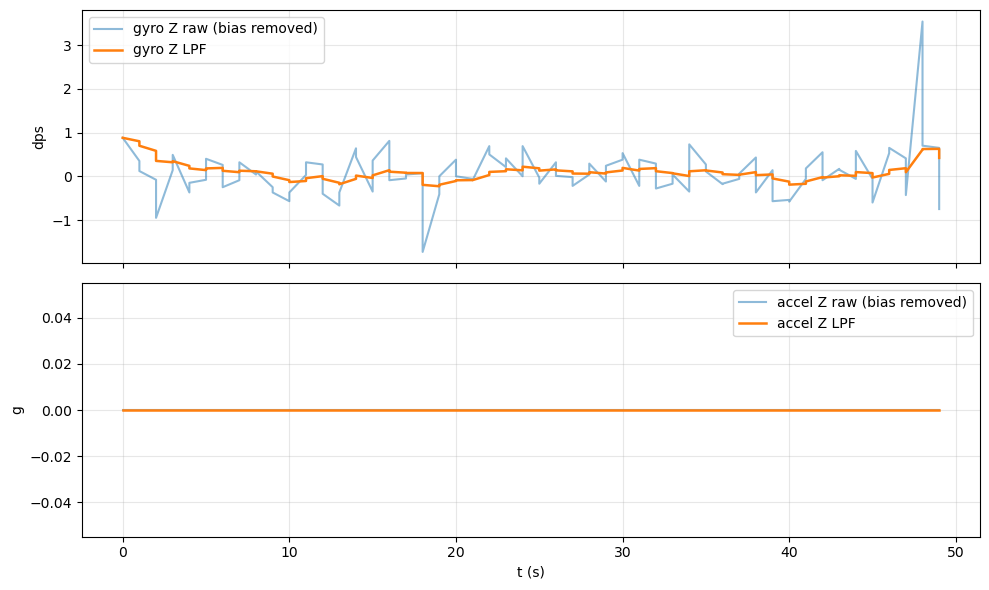

In [4]:
# Low-pass filtered gyro/accel vs raw (bias removed)
import numpy as np

if 'df_ts' not in globals() or df_ts.empty:
    raise RuntimeError('Run the time-stamped parsing cell first to populate df_ts')

# Compute dt from timestamps
df_filt = df_ts.copy().reset_index(drop=True)
df_filt['dt'] = df_filt['t_s'].diff().fillna(0.0)

# Bias from first 20 samples
bias_gx = df_filt['gx_dps'].head(20).mean()
bias_gy = df_filt['gy_dps'].head(20).mean()
bias_gz = df_filt['gz_dps'].head(20).mean()
bias_ax = df_filt['ax_g'].head(20).mean()
bias_ay = df_filt['ay_g'].head(20).mean()
bias_az = df_filt['az_g'].head(20).mean()

# Simple exponential LPF
alpha = 0.15
# Gyro: subtract numeric bias values, store bias-removed and LPF
for col, bval, out_raw in [
    ('gx_dps', bias_gx, 'gx_dps_bias'),
    ('gy_dps', bias_gy, 'gy_dps_bias'),
    ('gz_dps', bias_gz, 'gz_dps_bias'),
]:
    raw = df_filt[col] - bval
    filt = []
    acc = None
    for v in raw:
        acc = v if acc is None else acc + alpha * (v - acc)
        filt.append(acc)
    df_filt[out_raw] = raw
    df_filt[col + '_lpf'] = filt
# Accel: bias remove and LPF
for col, bval in [('ax_g', bias_ax), ('ay_g', bias_ay), ('az_g', bias_az)]:
    raw = df_filt[col] - bval
    filt = []
    acc = None
    for v in raw:
        acc = v if acc is None else acc + alpha * (v - acc)
        filt.append(acc)
    df_filt[col + '_lpf'] = filt

display(df_filt[['ax_g_lpf','ay_g_lpf','az_g_lpf','gx_dps_lpf','gy_dps_lpf','gz_dps_lpf']].head())

display(df_filt.head())

fig, axes = plt.subplots(2, 1, figsize=(10,6), sharex=True)
# Raw vs LPF gyro Z
axes[0].plot(df_filt['t_s'], df_filt['gz_dps'] - bias_gz, label='gyro Z raw (bias removed)', alpha=0.5)
axes[0].plot(df_filt['t_s'], df_filt['gz_dps_lpf'], label='gyro Z LPF', linewidth=1.8)
axes[0].set_ylabel('dps')
axes[0].grid(True, alpha=0.3)
axes[0].legend()
# Raw vs LPF accel Z
axes[1].plot(df_filt['t_s'], df_filt['az_g'] - bias_az, label='accel Z raw (bias removed)', alpha=0.5)
axes[1].plot(df_filt['t_s'], df_filt['az_g_lpf'], label='accel Z LPF', linewidth=1.8)
axes[1].set_ylabel('g')
axes[1].set_xlabel('t (s)')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
plt.tight_layout()
plt.show()



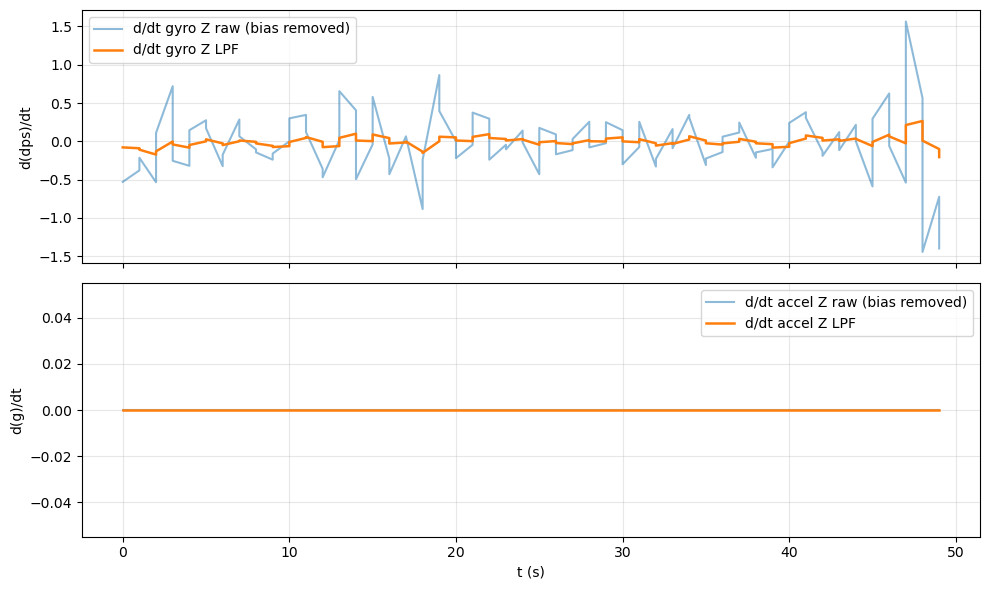

In [5]:
# Rate of change (derivative) comparison: gyro Z and accel Z (raw bias-removed vs LPF)
import numpy as np

if 'df_filt' not in globals() or df_filt.empty:
    raise RuntimeError('Run the LPF cell first to build df_filt')

# Time vector
t = df_filt['t_s'].to_numpy()
# Gyro Z
gz_raw = df_filt['gz_dps_bias']
gz_lpf = df_filt['gz_dps_lpf']
# Accel Z
az_raw = df_filt['az_g'] - bias_az
az_lpf = df_filt['az_g_lpf']

# Derivatives
if len(t) > 1:
    dt = np.diff(t)
    # if any zero/negative spacing, fall back to uniform spacing
    if np.any(dt <= 0):
        dt_mean = float(np.mean(dt[dt > 0])) if np.any(dt > 0) else 1.0
        dgz_raw = np.gradient(gz_raw, dt_mean)
        dgz_lpf = np.gradient(gz_lpf, dt_mean)
        daz_raw = np.gradient(az_raw, dt_mean)
        daz_lpf = np.gradient(az_lpf, dt_mean)
    else:
        dgz_raw = np.gradient(gz_raw, t)
        dgz_lpf = np.gradient(gz_lpf, t)
        daz_raw = np.gradient(az_raw, t)
        daz_lpf = np.gradient(az_lpf, t)
else:
    dgz_raw = dgz_lpf = daz_raw = daz_lpf = np.array([0.0])

fig, axes = plt.subplots(2, 1, figsize=(10,6), sharex=True)
axes[0].plot(t, dgz_raw, label='d/dt gyro Z raw (bias removed)', alpha=0.5)
axes[0].plot(t, dgz_lpf, label='d/dt gyro Z LPF', linewidth=1.8)
axes[0].set_ylabel('d(dps)/dt')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].plot(t, daz_raw, label='d/dt accel Z raw (bias removed)', alpha=0.5)
axes[1].plot(t, daz_lpf, label='d/dt accel Z LPF', linewidth=1.8)
axes[1].set_ylabel('d(g)/dt')
axes[1].set_xlabel('t (s)')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()


                 mean       std       min           max
gx_dps_bias  0.009303  0.046036 -0.101000  1.690000e-01
gy_dps_bias  0.050551  0.198727 -0.444500  1.135500e+00
gz_dps_bias  0.078157  0.547296 -1.727500  3.542500e+00
ax_g_lpf    -0.002384  0.001365 -0.004000  7.092993e-04
ay_g_lpf    -0.000248  0.000425 -0.001611 -1.110223e-16
az_g_lpf     0.000000  0.000000  0.000000  0.000000e+00


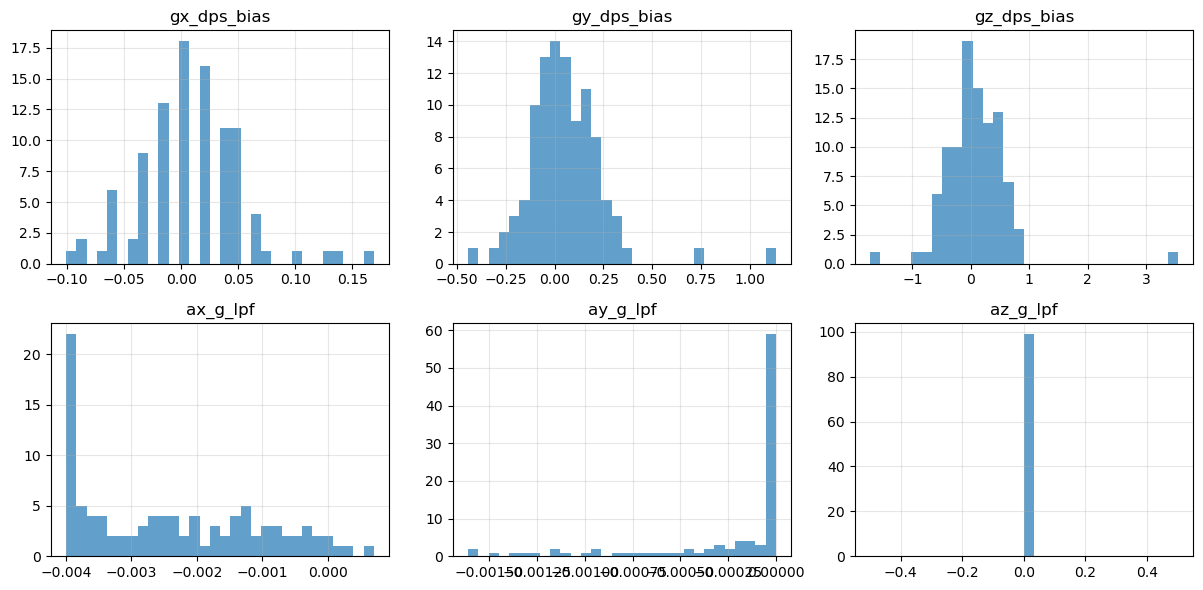

In [7]:
# Baseline stats and histograms for noise (using LPF’d + bias-removed signals)
import numpy as np

if 'df_filt' not in globals() or df_filt.empty:
    raise RuntimeError('Run the LPF cell first')

stats = {}
for col in ['gx_dps_bias','gy_dps_bias','gz_dps_bias',
            'ax_g_lpf','ay_g_lpf','az_g_lpf']:
    s = df_filt[col]
    stats[col] = {
        'mean': float(s.mean()),
        'std': float(s.std()),
        'min': float(s.min()),
        'max': float(s.max()),
    }

print(pd.DataFrame(stats).T)

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
cols = ['gx_dps_bias','gy_dps_bias','gz_dps_bias',
        'ax_g_lpf','ay_g_lpf','az_g_lpf']
for ax, col in zip(axes.ravel(), cols):
    ax.hist(df_filt[col], bins=30, alpha=0.7)
    ax.set_title(col)
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

   gx_dps_lpf_db  gy_dps_lpf_db  gz_dps_lpf_db
0            0.0         0.3355       0.882500
1            0.0         0.0000       0.803000
2            0.0         0.0000       0.700925
3            0.0         0.0000       0.584161
4            0.0         0.0000       0.354412


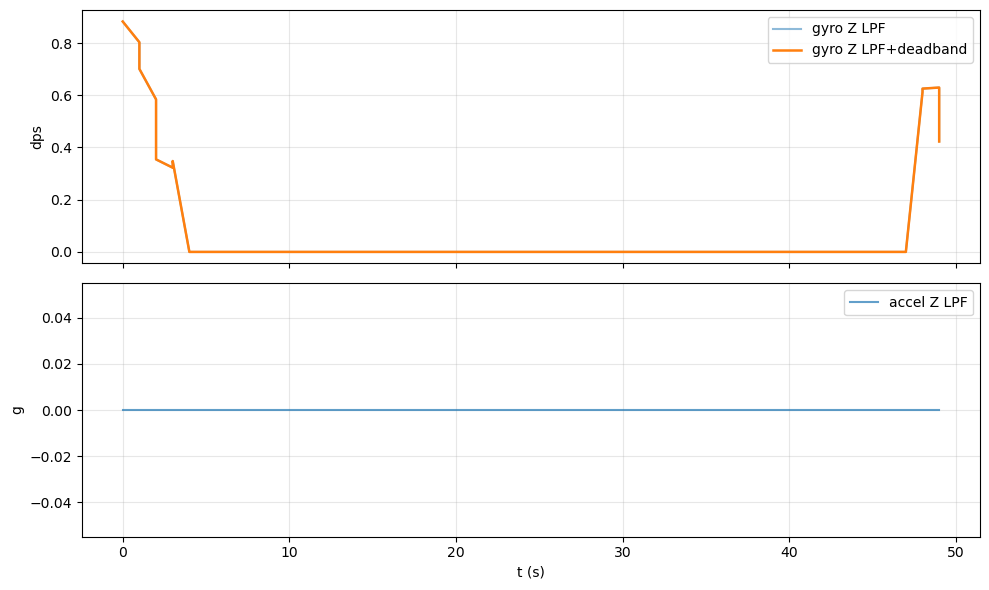

In [8]:
# Apply gyro deadband after bias+LPF to further suppress stationary jitter
# Requires df_filt from the LPF cell (bias removed + lpf columns)
import numpy as np

if 'df_filt' not in globals() or df_filt.empty:
    raise RuntimeError('Run the LPF cell first to build df_filt')

# Deadband threshold (dps)
DEADBAND = 0.3

df_dead = df_filt.copy()
for col in ['gx_dps_lpf', 'gy_dps_lpf', 'gz_dps_lpf']:
    db = df_dead[col].to_numpy()
    db[np.abs(db) < DEADBAND] = 0.0
    df_dead[col + '_db'] = db

print(df_dead[['gx_dps_lpf_db','gy_dps_lpf_db','gz_dps_lpf_db']].head())

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
# Gyro Z: LPF vs LPF+deadband
axes[0].plot(df_dead['t_s'], df_dead['gz_dps_lpf'], label='gyro Z LPF', alpha=0.5)
axes[0].plot(df_dead['t_s'], df_dead['gz_dps_lpf_db'], label='gyro Z LPF+deadband', linewidth=1.8)
axes[0].set_ylabel('dps')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Accel Z LPF unchanged (for comparison)
axes[1].plot(df_dead['t_s'], df_dead['az_g_lpf'], label='accel Z LPF', alpha=0.7)
axes[1].set_ylabel('g')
axes[1].set_xlabel('t (s)')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()


,t_s,acc_angle_deg,gyro_angle_deg,comp_angle_deg
0,0.0,-90.0,-90.000000,-90.000000
1,1.0,-90.0,-89.984000,-89.984800
2,1.0,-90.0,-89.984000,-89.984800
3,2.0,-90.0,-89.966493,-89.968168
4,2.0,-90.0,-89.966493,-89.968168


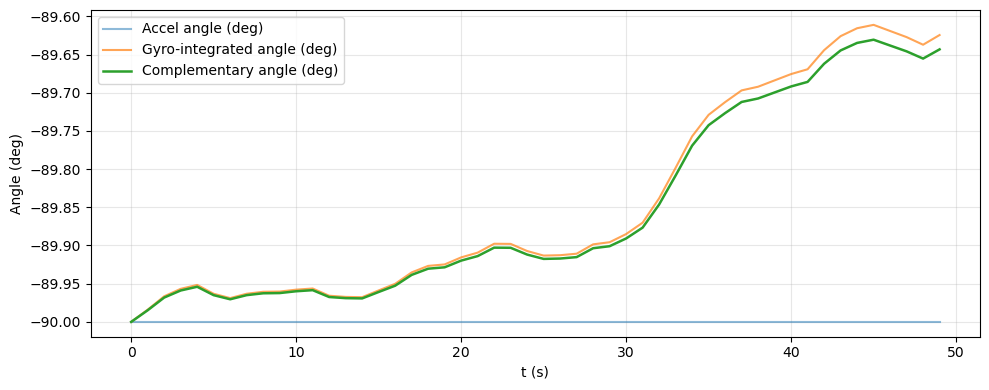

In [6]:
# Complementary filter (gyro X integrated vs accel-derived tilt) vs raw
import numpy as np

if 'df_filt' not in globals() or df_filt.empty:
    raise RuntimeError('Run the LPF cell first to build df_filt')

# Accel tilt around X (pitch) using ay, az (LPF’d)
df_comp = df_filt.copy()
if not set(['ay_g_lpf','az_g_lpf','gx_dps_lpf']).issubset(df_comp.columns):
    raise RuntimeError('LPF columns missing; run the LPF cell first')
df_comp['acc_angle_deg'] = np.degrees(np.arctan2(df_comp['ay_g_lpf'], df_comp['az_g_lpf']))

# Integrate gyro X (gx_dps_lpf) to angle, start at accel angle
angle = []
ang = df_comp['acc_angle_deg'].iloc[0] if not df_comp.empty else 0.0
for gx, dt in zip(df_comp['gx_dps_lpf'], df_comp['dt']):
    ang += gx * dt  # gx in dps, dt in s -> degrees
    angle.append(ang)
df_comp['gyro_angle_deg'] = angle

# Complementary fuse
comp_alpha = 0.05  # trust accel 5%, gyro 95%
comp_angle = []
ang_c = df_comp['acc_angle_deg'].iloc[0] if not df_comp.empty else 0.0
for g_ang, a_ang in zip(df_comp['gyro_angle_deg'], df_comp['acc_angle_deg']):
    ang_c = (1 - comp_alpha) * g_ang + comp_alpha * a_ang
    comp_angle.append(ang_c)
df_comp['comp_angle_deg'] = comp_angle

display(df_comp[['t_s','acc_angle_deg','gyro_angle_deg','comp_angle_deg']].head())

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(df_comp['t_s'], df_comp['acc_angle_deg'], label='Accel angle (deg)', alpha=0.5)
ax.plot(df_comp['t_s'], df_comp['gyro_angle_deg'], label='Gyro-integrated angle (deg)', alpha=0.7)
ax.plot(df_comp['t_s'], df_comp['comp_angle_deg'], label='Complementary angle (deg)', linewidth=1.8)
ax.set_xlabel('t (s)')
ax.set_ylabel('Angle (deg)')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()



                    ts   gx   gy   gz      ax      ay      az  \
0  2025-12-09 02:25:42  0.0  0.0  0.0 -0.4656  0.6191 -0.6074   
1  2025-12-09 02:25:42  0.0  0.0  0.0 -0.4651  0.6147 -0.6025   
2  2025-12-09 02:25:42  0.0  0.0  0.0 -0.4626  0.6138 -0.6030   
3  2025-12-09 02:25:42  0.0  0.0  0.0 -0.4641  0.6155 -0.6050   
4  2025-12-09 02:25:42  0.0  0.0  0.0 -0.4658  0.6179 -0.6067   

                    t  t_s  
0 2025-12-09 02:25:42  0.0  
1 2025-12-09 02:25:42  0.0  
2 2025-12-09 02:25:42  0.0  
3 2025-12-09 02:25:42  0.0  
4 2025-12-09 02:25:42  0.0  
rows: 1374


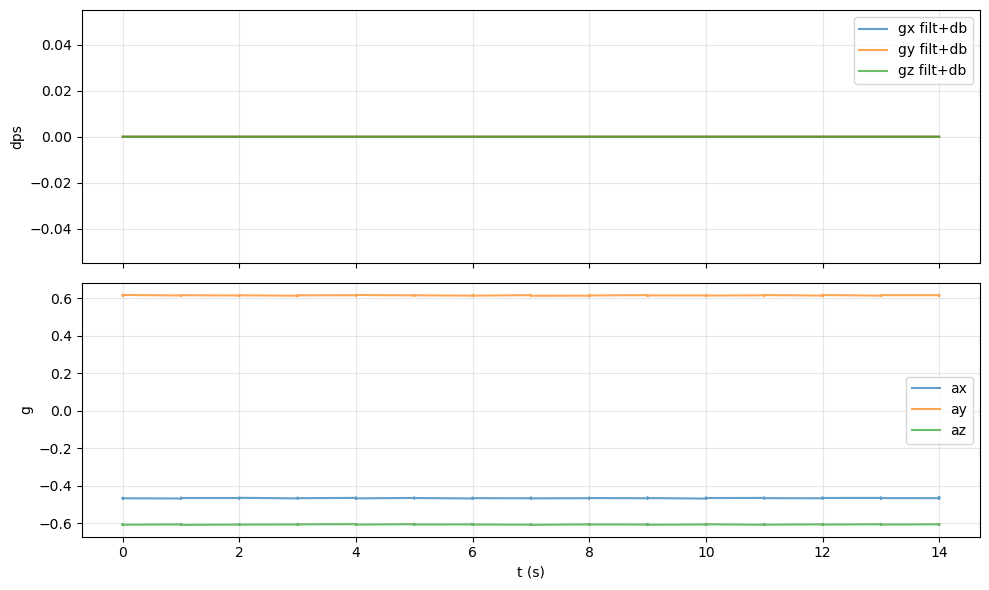

In [10]:
# Plot filtered outputs from current serial.log (gyro filt+db and accel)
import re
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

LOG_PATH = Path("/mnt/c/Users/tjsin/Downloads/Competition/LINE-FOLLOWER/serial.log")
if not LOG_PATH.exists():
    raise RuntimeError("serial.log not found")

re_line = re.compile(
    r"\[(?P<ts>[^\]]+)\]\s*Gyro filt\+db \(dps\):\s*(?P<gx>[-0-9.+]+),\s*(?P<gy>[-0-9.+]+),\s*(?P<gz>[-0-9.+]+)\s*\|\s*Accel \(g\):\s*(?P<ax>[-0-9.+]+),\s*(?P<ay>[-0-9.+]+),\s*(?P<az>[-0-9.+]+)"
)
rows = []
with LOG_PATH.open(errors='ignore') as f:
    for line in f:
        m = re_line.search(line)
        if m:
            rows.append({
                "ts": m.group("ts"),
                "gx": float(m.group("gx")),
                "gy": float(m.group("gy")),
                "gz": float(m.group("gz")),
                "ax": float(m.group("ax")),
                "ay": float(m.group("ay")),
                "az": float(m.group("az")),
            })

df_log = pd.DataFrame(rows)
if df_log.empty:
    raise RuntimeError("No filtered samples parsed from serial.log")

df_log["t"] = pd.to_datetime(df_log["ts"])
t0 = df_log["t"].iloc[0]
df_log["t_s"] = (df_log["t"] - t0).dt.total_seconds()

print(df_log.head())
print("rows:", len(df_log))

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axes[0].plot(df_log["t_s"], df_log["gx"], label="gx filt+db", alpha=0.7)
axes[0].plot(df_log["t_s"], df_log["gy"], label="gy filt+db", alpha=0.7)
axes[0].plot(df_log["t_s"], df_log["gz"], label="gz filt+db", alpha=0.7)
axes[0].set_ylabel("dps")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].plot(df_log["t_s"], df_log["ax"], label="ax", alpha=0.7)
axes[1].plot(df_log["t_s"], df_log["ay"], label="ay", alpha=0.7)
axes[1].plot(df_log["t_s"], df_log["az"], label="az", alpha=0.7)
axes[1].set_ylabel("g")
axes[1].set_xlabel("t (s)")
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()



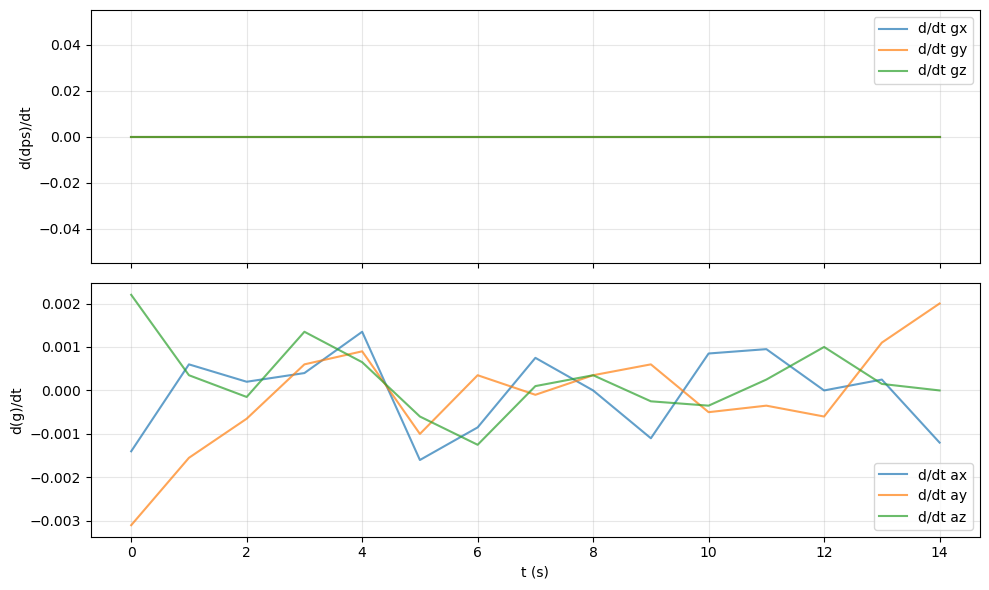

In [13]:
# d/dt from filtered log (filt+deadband) with deduped timestamps
if 'df_log' not in globals() or df_log.empty:
    raise RuntimeError('Run the filtered log parse cell first')

_df = df_log.drop_duplicates(subset='t_s').reset_index(drop=True)

t = _df['t_s'].to_numpy()
gx, gy, gz = _df['gx'].to_numpy(), _df['gy'].to_numpy(), _df['gz'].to_numpy()
ax, ay, az = _df['ax'].to_numpy(), _df['ay'].to_numpy(), _df['az'].to_numpy()

if len(t) > 1:
    dt = np.diff(t)
    dt_mean = float(np.mean(dt[dt > 0])) if np.any(dt > 0) else 1.0
    dgx = np.gradient(gx, dt_mean)
    dgy = np.gradient(gy, dt_mean)
    dgz = np.gradient(gz, dt_mean)
    dax = np.gradient(ax, dt_mean)
    day = np.gradient(ay, dt_mean)
    daz = np.gradient(az, dt_mean)
else:
    dgx = dgy = dgz = dax = day = daz = np.array([0.0])

fig, axes = plt.subplots(2,1, figsize=(10,6), sharex=True)
axes[0].plot(t, dgx, label='d/dt gx', alpha=0.7)
axes[0].plot(t, dgy, label='d/dt gy', alpha=0.7)
axes[0].plot(t, dgz, label='d/dt gz', alpha=0.7)
axes[0].set_ylabel('d(dps)/dt'); axes[0].grid(True, alpha=0.3); axes[0].legend()

axes[1].plot(t, dax, label='d/dt ax', alpha=0.7)
axes[1].plot(t, day, label='d/dt ay', alpha=0.7)
axes[1].plot(t, daz, label='d/dt az', alpha=0.7)
axes[1].set_ylabel('d(g)/dt'); axes[1].set_xlabel('t (s)'); axes[1].grid(True, alpha=0.3); axes[1].legend()

plt.tight_layout(); plt.show()


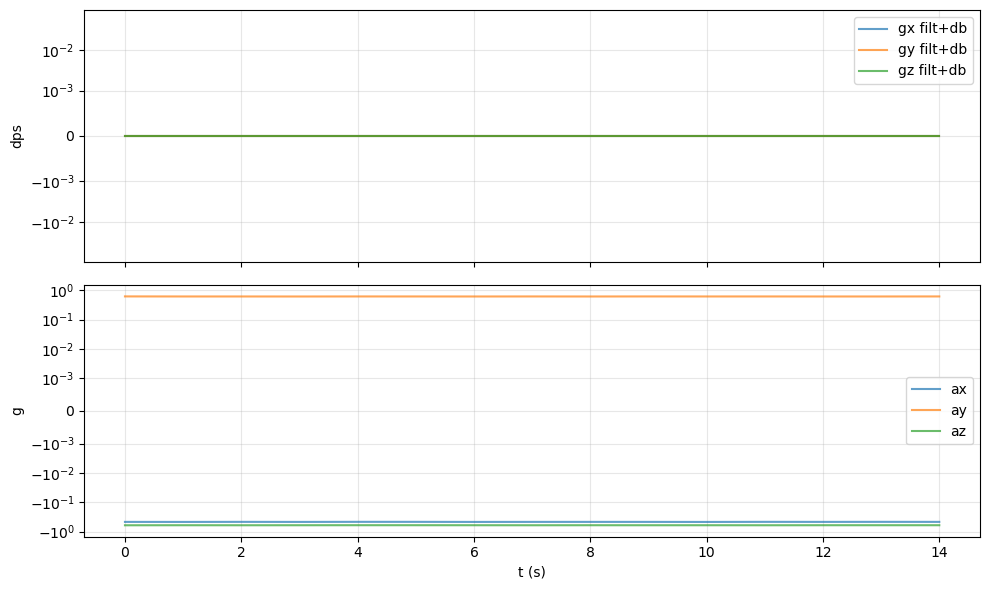

In [14]:
# Log-scale view of filtered outputs (gyro filt+db and accel)
import matplotlib.pyplot as plt
import numpy as np

if 'df_log' not in globals() or df_log.empty:
    raise RuntimeError('Run the filtered log parse cell first')

_df = df_log.drop_duplicates(subset='t_s').reset_index(drop=True)
t = _df['t_s']

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axes[0].plot(t, _df['gx'], label='gx filt+db', alpha=0.7)
axes[0].plot(t, _df['gy'], label='gy filt+db', alpha=0.7)
axes[0].plot(t, _df['gz'], label='gz filt+db', alpha=0.7)
axes[0].set_ylabel('dps')
axes[0].set_yscale('symlog', linthresh=1e-3)
axes[0].grid(True, alpha=0.3, which='both')
axes[0].legend()

axes[1].plot(t, _df['ax'], label='ax', alpha=0.7)
axes[1].plot(t, _df['ay'], label='ay', alpha=0.7)
axes[1].plot(t, _df['az'], label='az', alpha=0.7)
axes[1].set_ylabel('g')
axes[1].set_xlabel('t (s)')
axes[1].set_yscale('symlog', linthresh=1e-3)
axes[1].grid(True, alpha=0.3, which='both')
axes[1].legend()

plt.tight_layout()
plt.show()